In [2]:
import geopandas as gpd
import pandas as pd




In [15]:
# load duration data

duration_orig = gpd.read_file('../data/derived_data/flats_duration.gpkg')
duration_iso = gpd.read_file('../data/derived_data/flats_duration_iso.gpkg')
duration_ors = gpd.read_file('../data/derived_data/flats_duration_ors.gpkg')


In [45]:
# Calculate population weighted duration for each dataset
orig_weighted = (duration_orig['duration'] * duration_orig['est_pop']).sum() / duration_orig['est_pop'].sum()
iso_weighted = (duration_iso['duration_min'] * duration_iso['est_pop']).sum() / duration_iso['est_pop'].sum()
ors_weighted = (duration_ors['duration'] * duration_ors['est_pop']).sum() / duration_ors['est_pop'].sum()

# Calculate population outside 10-minute range for each dataset
orig_outside = duration_orig[duration_orig['duration'] > 10]['est_pop'].sum()
iso_outside = duration_iso[duration_iso['duration_min'] > 10]['est_pop'].sum()
ors_outside = duration_ors[duration_ors['duration'] > 10]['est_pop'].sum()

# Calculate total population
total_pop = duration_orig['est_pop'].sum()

# Calculate coverage percentage for each dataset
orig_coverage = ((total_pop - orig_outside) / total_pop) * 100
iso_coverage = ((total_pop - iso_outside) / total_pop) * 100
ors_coverage = ((total_pop - ors_outside) / total_pop) * 100

# Function to format time in min:sec
def format_time(minutes):
    mins = int(minutes)
    secs = int((minutes - mins) * 60)
    return f"{mins}:{secs:02d}"

# Create a DataFrame with the comparison results
comparison_df = pd.DataFrame({
    'Method': ['Current Situation', 'Iso+Clustering', 'ORS+Clustering'],
    'Population Outside 10min': [orig_outside, iso_outside, ors_outside],
    'Coverage (%)': [orig_coverage, iso_coverage, ors_coverage],
    'Average Walking Time (min)': [format_time(orig_weighted), format_time(iso_weighted), format_time(ors_weighted)],
    'Number of additional RCPs': [0, 10, 12]
})


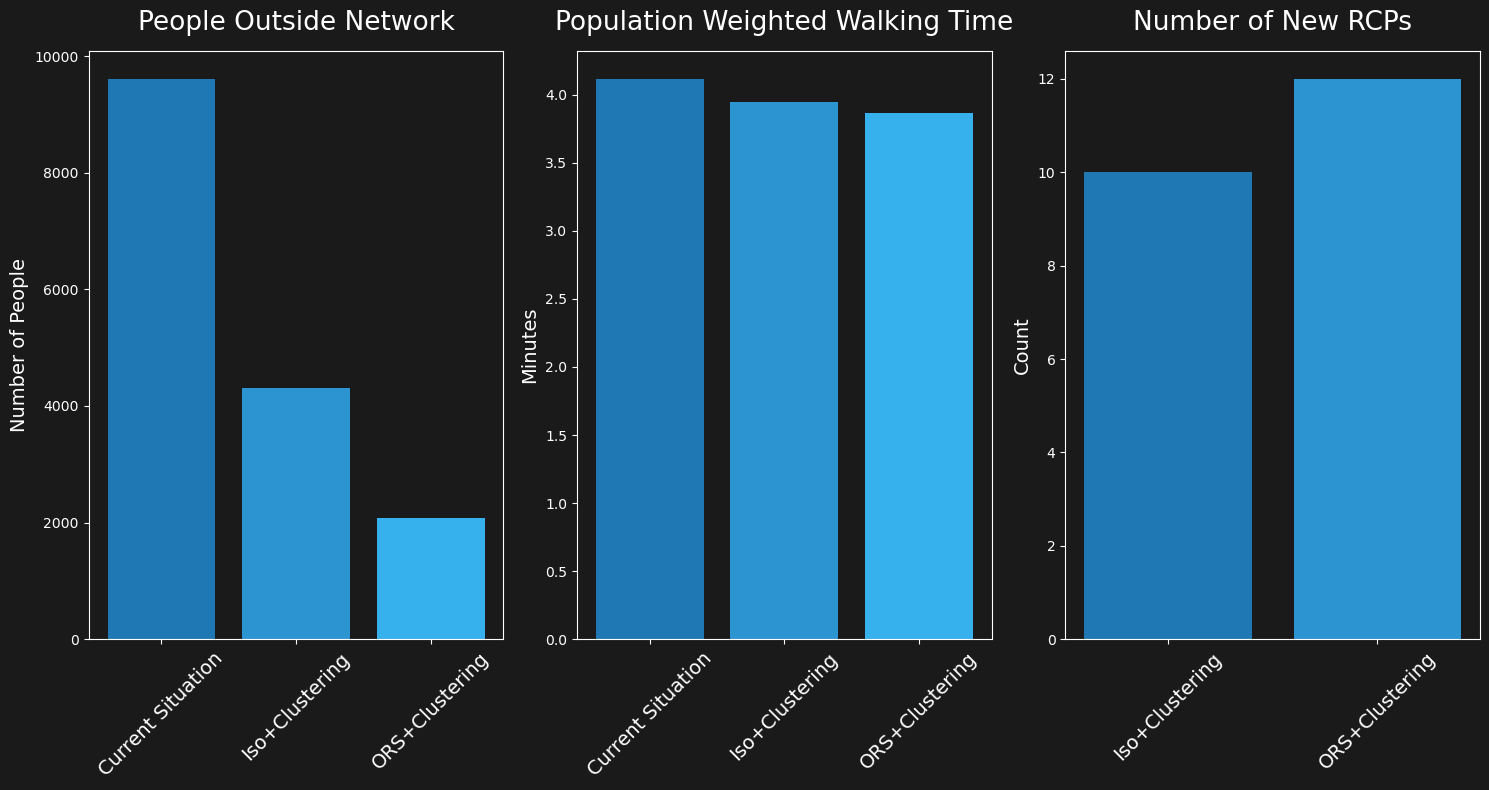

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Font size parameters
TITLE_SIZE = 19
LABEL_SIZE = 14
TICK_SIZE = 14

# Set dark theme style
plt.style.use('dark_background')

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
fig.patch.set_facecolor('#1a1a1a')

# Define blue color palette
colors = ['#1f77b4', '#2b94d1', '#37b0ee']

# Plot 1: People outside the network
ax1.bar(comparison_df['Method'], comparison_df['Population Outside 10min'], color=colors)
ax1.set_title('People Outside Network', pad=15, fontsize=TITLE_SIZE)
ax1.set_ylabel('Number of People', fontsize=LABEL_SIZE)
ax1.tick_params(axis='x', rotation=45, labelsize=TICK_SIZE)
ax1.set_facecolor('#1a1a1a')

# Plot 2: Walking time
walking_times = [float(t.split(':')[0]) + float(t.split(':')[1])/60 for t in comparison_df['Average Walking Time (min)']]
ax2.bar(comparison_df['Method'], walking_times, color=colors)
ax2.set_title('Population Weighted Walking Time', pad=15, fontsize=TITLE_SIZE)
ax2.set_ylabel('Minutes', fontsize=LABEL_SIZE)
ax2.tick_params(axis='x', rotation=45, labelsize=TICK_SIZE)
ax2.set_facecolor('#1a1a1a')

# Plot 3: Number of New RCPs
ax3.bar(comparison_df['Method'][1:], comparison_df['Number of additional RCPs'][1:], color=colors[:-1])
ax3.set_title('Number of New RCPs', pad=15, fontsize=TITLE_SIZE)
ax3.set_ylabel('Count', fontsize=LABEL_SIZE)
ax3.tick_params(axis='x', rotation=45, labelsize=TICK_SIZE)
ax3.set_facecolor('#1a1a1a')

# save plot
plt.savefig('../data/plots/method_comparison.png', dpi=400, bbox_inches='tight', facecolor='#1a1a1a')

plt.tight_layout()
plt.show()


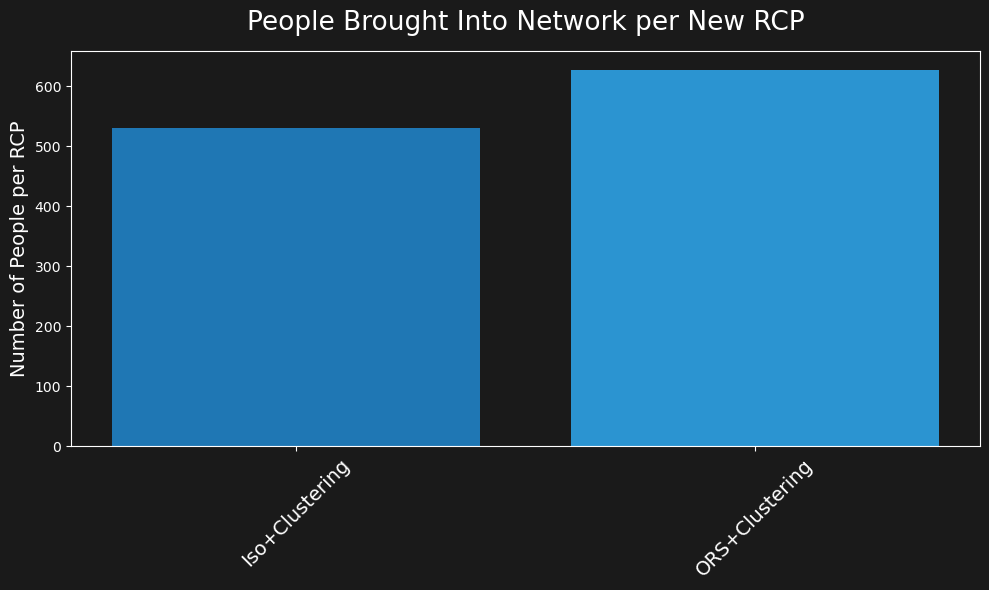

In [53]:
# Calculate people brought in by comparing to current situation
people_brought_in = comparison_df.loc[0, 'Population Outside 10min'] - comparison_df.loc[1:, 'Population Outside 10min']
new_rcps = comparison_df.loc[1:, 'Number of additional RCPs']

# Calculate people per RCP
people_per_rcp = people_brought_in / new_rcps

# Create figure with dark theme
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')

# Plot the data
plt.bar(comparison_df['Method'][1:], people_per_rcp, color=colors[0:2])

# Customize the plot
plt.title('People Brought Into Network per New RCP', fontsize=TITLE_SIZE, color='white', pad=15)
plt.ylabel('Number of People per RCP', fontsize=LABEL_SIZE, color='white')
plt.xticks(rotation=45, fontsize=TICK_SIZE, color='white')
plt.gca().set_facecolor('#1a1a1a')
plt.gca().tick_params(colors='white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

plt.tight_layout()

# Save and show the plot
plt.savefig('../data/plots/people_brought_in_per_rcp.png', dpi=400, bbox_inches='tight', facecolor='#1a1a1a')
plt.show()


In [71]:
from mdutils import MdUtils
import shutil
# Round the numbers in the DataFrame
comparison_df_rounded = comparison_df.copy()
comparison_df_rounded['Population Outside 10min'] = comparison_df['Population Outside 10min'].round(0)
comparison_df_rounded['Coverage (%)'] = comparison_df['Coverage (%)'].round(2)

# Create markdown file
mdFile = MdUtils(file_name='../data/plots/comparison_table.md')

# Add title
mdFile.write("\n## Comparison Table\n")

# Create table header
headers = comparison_df_rounded.columns.tolist()
table = [headers]

# Add rows
for _, row in comparison_df_rounded.iterrows():
    table.append([str(val) for val in row.values])

# Create table with mdutils
mdFile.new_table(columns=len(headers), rows=len(table), text=sum(table, []))

# Create file
mdFile.create_md_file()

IndexError: list index out of range